In [344]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose


In [345]:
with open("data/selected_data.pickle", "rb") as f:
    data = pickle.load(f)

In [346]:
train = data["train"]
train_points = train["points"]
train_groups = train["groups"]

val = data["val"]
val_points = val["points"]
val_groups = val["groups"]

In [347]:
np.flip(np.argsort(list(map(lambda x: (x > 0).sum(), train_groups))))[:10]

array([ 682, 1078,  636, 1291,  284, 1003, 1337, 1433, 1256, 1448])

In [348]:
SAMPLE_ID = 1448

In [349]:
series = train_groups[SAMPLE_ID].copy()

In [350]:
df = series.to_frame().reset_index()
df["timestamp"] = df["timestamp"].apply(datetime.datetime.fromtimestamp)
df["year_day"] = df["timestamp"].apply(lambda x: x.day_of_year)
series_per_day = df.groupby("year_day").apply(lambda x: x["n_pubs"].mean())
result_per_day = seasonal_decompose(series_per_day, period=31, model='additive', extrapolate_trend="freq")
# result_per_day.plot()

In [351]:
to_substract = (result_per_day.trend + result_per_day.seasonal).to_frame("t+s").reset_index()
df2 = df.merge(to_substract, on="year_day")
df2 = df2.set_index("timestamp")
df2["n_pubs"] -= df2["t+s"]
series_per_hour = df2["n_pubs"]

In [352]:
result_per_hour = seasonal_decompose(series_per_hour, period=24, model='additive', extrapolate_trend="freq")

In [353]:
df3 = (result_per_hour.trend+ result_per_hour.seasonal).to_frame("amount").reset_index()
df3["year_day"] = df3["timestamp"].apply(lambda x: x.day_of_year)
to_add = (result_per_day.trend + result_per_day.seasonal).to_frame("t+s").reset_index()
df3 = df3.merge(to_substract, on="year_day")
df3["amount"] += df3["t+s"]
df3 = df3.set_index("timestamp")
result = df3["amount"]

In [354]:
series_ = series.to_frame().reset_index()
series_["timestamp"] = series_["timestamp"].apply(datetime.datetime.fromtimestamp)
series_ = series_.set_index("timestamp")
series_ = series_["n_pubs"]

In [355]:
residual = series_ - result

In [356]:
df_ = residual.to_frame("amount").reset_index()
df_["hour"] = df_["timestamp"].apply(lambda x: x.hour)
df_["year_day"] = df_["timestamp"].apply(lambda x: x.day_of_year)
x = df_[["hour", "year_day"]].to_numpy()
y = df_["amount"].to_numpy()


In [357]:
resid_regr = RandomForestRegressor()
resid_regr.fit(x, y)

RandomForestRegressor()

In [358]:
resid_pred = resid_regr.predict(x)

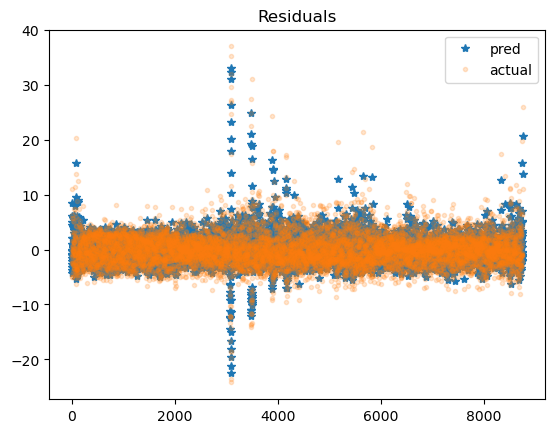

In [359]:
plt.plot(resid_pred, ls="", marker="*", label="pred")
plt.plot(y, ls="", marker=".", alpha=0.2, label="actual")
plt.title("Residuals")
plt.legend()
plt.show()

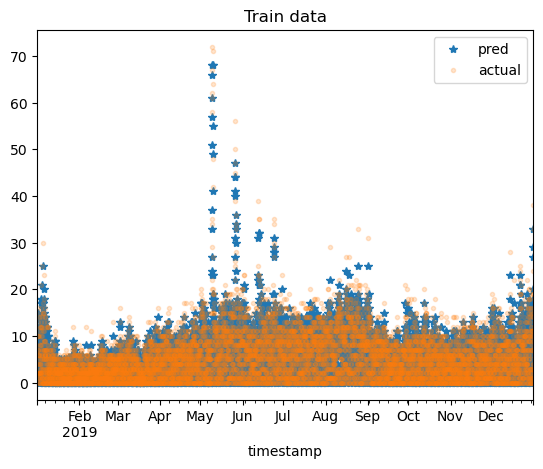

In [360]:
result_ = result.copy()
result_ += resid_pred
result_[result_ < 0] = 0
result_ = result_.apply(np.round)
result_.plot(ls="", marker="*", label="pred")
series_.plot(ls="", marker=".", alpha=0.2, label="actual")
plt.title("Train data")
plt.legend()
plt.show()

In [361]:
mean_absolute_error(result_, series_)

0.6840242092040654

# Validation

In [362]:
val_series = val_groups[SAMPLE_ID].copy()

In [363]:
val_series_ = val_series.to_frame().reset_index()
val_series_["timestamp"] = val_series_["timestamp"].apply(datetime.datetime.fromtimestamp)
val_series_["timestamp"] -= datetime.timedelta(days=365)
val_series_ = val_series_.set_index("timestamp")
val_series_ = val_series_["n_pubs"]

In [364]:
start = val_series_.index.min()
end = val_series_.index.max()

In [365]:
val_result_ = result.copy()
val_result_ = val_result_.loc[start: end]

In [366]:
df_ = val_series_.to_frame("amount").reset_index()
df_["hour"] = df_["timestamp"].apply(lambda x: x.hour)
df_["year_day"] = df_["timestamp"].apply(lambda x: x.day_of_year)
val_x = df_[["hour", "year_day"]].to_numpy()

In [367]:
val_resid_pred = resid_regr.predict(val_x)
val_resid_pred = pd.Series(index=df_["timestamp"], data=val_resid_pred)

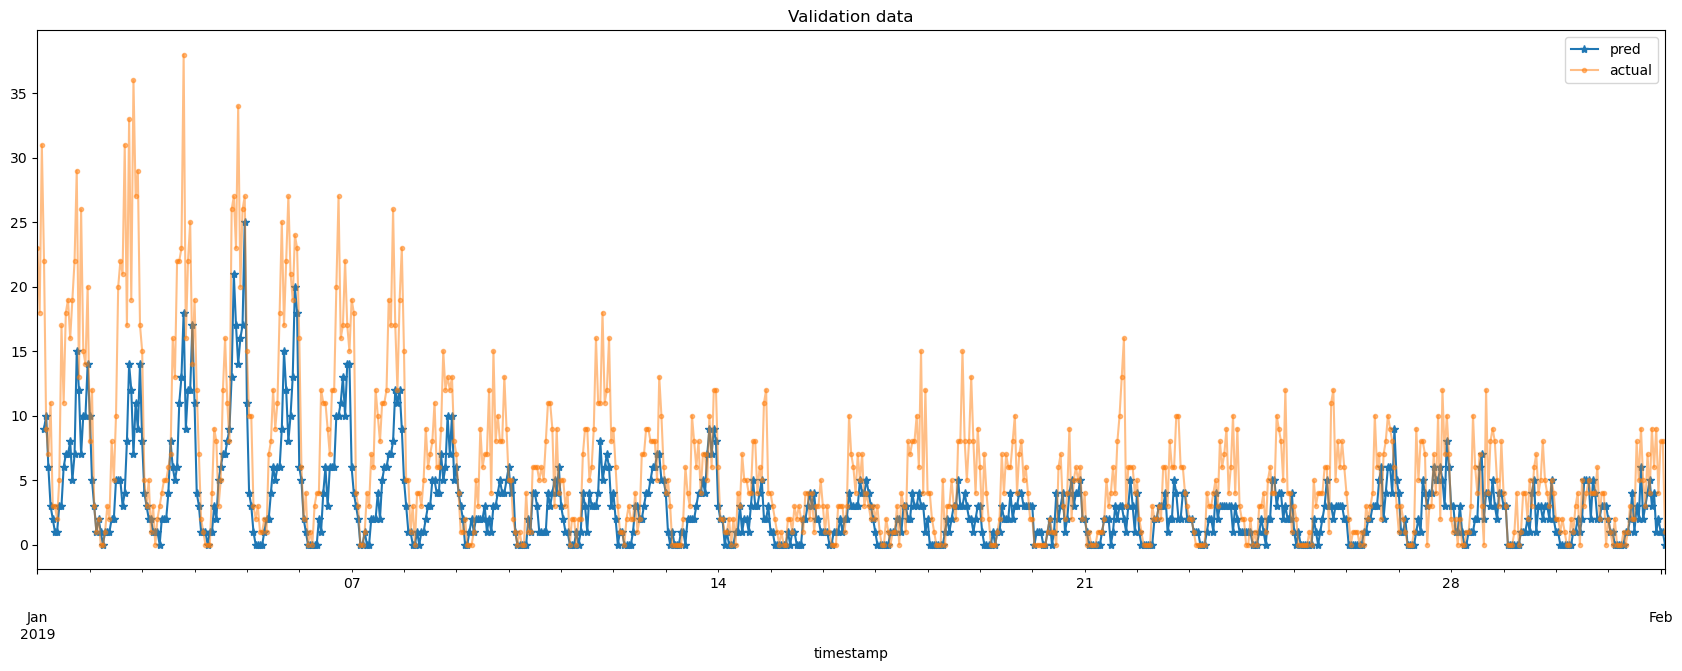

In [368]:
plt.figure(figsize=(21, 7))
val_result_ += val_resid_pred
val_result_[val_result_ < 0] = 0
val_result_ = val_result_.apply(np.round)
val_result_.plot(ls="-", marker="*", label="pred")
val_series_.plot(ls="-", marker=".", alpha=0.5, label="actual")
plt.title("Validation data")
plt.legend()
plt.show()

In [369]:
mean_absolute_error(val_result_, val_series_[val_result_.index])

3.3346774193548385